---

03/2019 <p style="text-align: right">Anton Panchenko</p>


![Titanic](https://cdn-static.denofgeek.com/sites/denofgeek/files/styles/main_wide/public/2015/10/raise-main.jpg?itok=QBxamb0z)

In [44]:
from sys import version_info
print("python:", version_info)

import os
import re
import numpy as np
print("numpy", np.__version__)

import pandas as pd
print("pandas", pd.__version__)

import seaborn as sns
print("seaborn", sns.__version__)

from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics

import xgboost as xgb
print("xgboost", xgb.__version__)

os.listdir("../input")

python: sys.version_info(major=3, minor=7, micro=2, releaselevel='final', serial=0)
numpy 1.16.2
pandas 0.24.1
seaborn 0.9.0
xgboost 0.82


['gender_submission.csv', 'test.csv', 'train.csv']

## Introduction

Load and merge datasets, meet data

In [25]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
data = train.append(test, sort=False)
data.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
885,886,0.0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
223,224,0.0,3,"Nenkoff, Mr. Christo",male,NaN,0,0,349234,7.8958,NaN,S
75,967,NaN,1,"Keeping, Mr. Edwin",male,32.5,0,0,113503,211.5000,C132,C
276,1168,NaN,2,"Parker, Mr. Clifford Richard",male,28.0,0,0,SC 14888,10.5000,NaN,S
871,872,1.0,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S


Look at types and incomplete features

In [26]:
def count(df:pd.DataFrame):
    stat = pd.DataFrame([df.dtypes, df.count()], index=['dtypes', 'count'])
    return stat.sort_values(by=['count'], axis=1, ascending=False)

count(data)

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked,Age,Survived,Cabin
dtypes,int64,int64,object,object,int64,int64,object,float64,object,float64,float64,object
count,1309,1309,1309,1309,1309,1309,1309,1308,1307,1046,891,295


It seems we have 1309 objects. Incomplete features are:
- Fare
- Embarked
- Age
- Cabin

## Create FamilySize and Alone features

In [27]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

data['Alone'] = 0
data.loc[data['FamilySize'] == 1, 'Alone'] = 1

def value_counts(feature:pd.Series):
    df = pd.DataFrame([feature.value_counts()], index=[feature.name + ' counts'])
    df['nans'] = feature.isna().sum()
    return df

value_counts(data['Alone'])

,1,0,nans
Alone counts,790,519,0


## Encode Sex

In [28]:
data['Sex'] = LabelEncoder().fit_transform(data['Sex'])

value_counts(data['Sex'])

,1,0,nans
Sex counts,843,466,0


## Extract Title from Name

In [29]:
data['Title'] = data['Name'].str.extract(r', (.*?)\.', expand=False)

value_counts(data['Title'])

,Mr,Miss,Mrs,Master,Dr,Rev,Col,Major,Mlle,Ms,Dona,Sir,Mme,Capt,Jonkheer,Lady,Don,the Countess,nans
Title counts,757,260,197,61,8,8,4,2,2,2,1,1,1,1,1,1,1,1,0


See [english honorifics](https://en.wikipedia.org/wiki/English_honorifics) for reference.

In [30]:
data['Title'].replace(['Mlle', 'Ms'], 'Miss', inplace=True)
data['Title'].replace(['Mme', 'Lady', 'Countess', 'Dona', 'the Countess'], 'Mrs', inplace=True)
data['Title'].replace(['Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer'], 'Mr', inplace=True)
value_counts(data['Title'])

,Mr,Miss,Mrs,Master,nans
Title counts,783,264,201,61,0


In [31]:
data['Title'] = LabelEncoder().fit_transform(data['Title'])

## Fix Fare

mae 14.569436846696348
score 0.5003303431712054


c:\dev\smurfy\.venv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\dev\smurfy\.venv\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


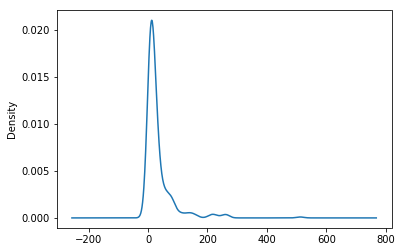

In [32]:
def infer(df:pd.DataFrame, features:np.array, target:str):
    # select training data and fit regressor
    train = df[df[target].notna()]
    x = train.loc[:, features]
    y = train.loc[:, target]
    #model = linear_model.LinearRegression().fit(x, y)
    model = xgb.XGBRegressor().fit(x, y)
    print('mae', metrics.mean_absolute_error(y, model.predict(x)))
    print('score', model.score(x, y))
    
    # predict missing target values
    na_mask = df[target].isna()
    predict = df[na_mask]
    x_predict = predict.loc[:, features]
    y_predict = model.predict(x_predict)

    # create new feature
    df[target + '_'] = df[target]
    df.loc[na_mask, target + '_'] = y_predict
    
infer(data, ['Pclass', 'SibSp', 'Title'], 'Fare')
# Sex and Parch - increase mae

#count(data)
data['Fare_'].plot.kde()

## Fix Age

mae 7.521876524059996
score 0.542715388050526


c:\dev\smurfy\.venv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\dev\smurfy\.venv\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


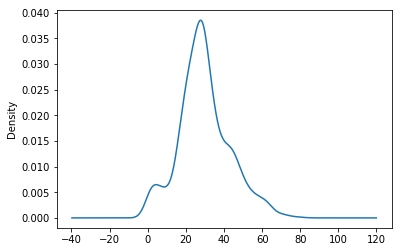

In [33]:
infer(data, ['Pclass', 'FamilySize', 'Title', 'Sex', 'Fare_'], 'Age')

#count(data)
data['Age_'].plot.kde()

## Encode and fix Embarked

In [61]:
def infer_cat(df:pd.DataFrame, features:np.array, target:str):
    # select training data and classifier
    train = df[df[target].notna()]
    x = train.loc[:, features]
    y = train.loc[:, target]
    parameters = {'max_depth': [3, 5],
                  'learning_rate': [0.1, 0.5],
                  'n_estimators': [100, 500]}
    model = model_selection.GridSearchCV(xgb.XGBClassifier(), parameters, cv=3).fit(x, y)
    print('Score', model.score(x, y))  
    print(model.best_params_)
    
    # predict missing target values
    na_mask = df[target].isna()
    x_predict = df[na_mask].loc[:, features]
    df[target + '_'] = df[target]
    df.loc[na_mask, target + '_'] = model.predict(x_predict)

# encode
notna = data['Embarked'].notna()
y = data[notna].loc[:, 'Embarked']
data.loc[notna, 'Embarked_'] = LabelEncoder().fit_transform(y)

infer_cat(data, ['Pclass', 'SibSp', 'Parch', 'Title', 'Fare_', 'Age_'], 'Embarked_')

value_counts(data['Embarked__'])

Score 0.9931140015302219
{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 500}


,2.0,0.0,1.0,nans
Embarked__ counts,915,271,123,0


## Finally predict Survived

In [54]:
train = data[data['Survived'].notna()]
test = data[data['Survived'].isna()]

# prepare train for fitting
# other features appears useless
features = ['Age_', 'Sex', 'Pclass', 'Fare_', 'FamilySize', 'Alone', 'Embarked__']
x = train.loc[:, features]
y = train.loc[:, 'Survived']
XTrain, XValid, YTrain, YValid = model_selection.train_test_split(x, y, test_size=0.2, random_state=40)

# train model
model = xgb.XGBClassifier(objective='binary:logistic', max_depth=4, reg_alpha=1, reg_lambda=0).fit(x, y)

def accuracy(Y: np.array, yPred: np.array) -> float:
  return np.sum(yPred==Y) / len(Y)

# use model to predict on training and validation sets
print('     Train accuracy', accuracy(YTrain, model.predict(XTrain)))
print('Validation accuracy', accuracy(YValid, model.predict(XValid)))

     Train accuracy 0.8974719101123596
Validation accuracy 0.9217877094972067


## Predict on test set

In [41]:
# predict for test set
XTest = test.loc[:, features]
YTest = model.predict(XTest)

## Save results

In [42]:
# create a Kaggle submission
sub = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': YTest.astype('int64')})
sub.to_csv('submission.csv', index=False)

## Thanks!!!